In [1]:
import torch 
import torch.nn as nn 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import scanpy as sc 
import numpy as np 

import matplotlib.pyplot as plt 
from pprint import pprint 

In [50]:
import HGT 
import svm
import data 
import utils 

from importlib import reload 

In [3]:
adata = data.preprocess_paul15(data.get_paul15(), flavor='seurat_v3', n_top_genes=100)
labels = torch.tensor(adata.obs.paul15_clusters_ind.values.astype(int)).long()
adata 

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/hbl/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/hbl/.local/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/data.py:130: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['paul15_clusters_ind'] = adata.obs.paul15_clusters.replace(cats.to_list(), range(len(cats)))


In [52]:
n_train = 1800 
x_train, x_test, y_train, y_test = svm.split_data_cellclass(adata, n_train, target_col='paul15_clusters_ind')
clf = svm.svm_cellclass(x_train, y_train, x_test, y_test, kernel='linear')

SVM test accuracy: 61.505376344086024


In [6]:
G, node_dict, edge_dict = HGT.get_heterograph_bipartite(adata, device=device)
print(G)
pprint(node_dict)
pprint(edge_dict)

Graph(num_nodes={'cell': 2730, 'gene': 100},
      num_edges={('cell', 'has-expression', 'gene'): 54381, ('gene', 'is-expressed', 'cell'): 54381},
      metagraph=[('cell', 'gene', 'has-expression'), ('gene', 'cell', 'is-expressed')])
{'cell': 0, 'gene': 1}
{'has-expression': 0, 'is-expressed': 1}


In [ ]:
def init_node_features(G, ):
    #     Random initialize input feature
    for ntype in G.ntypes:
        emb = nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), n_inp), requires_grad = False)
        nn.init.xavier_uniform_(emb)
        G.nodes[ntype].data['inp'] = emb.to(device)
    return G 

In [ ]:
def init_node_features(G, ):
    #     Random initialize input feature
    for ntype in G.ntypes:
        emb = nn.Embedding(G.number_of_nodes(ntype), n_inp)
        nn.init.xavier_uniform_(emb)
        G.nodes[ntype].data['inp'] = emb.to(device)
    return G 

TODO 
- learnable node features; split cell and gene feature init
- edge featrues: G.edata
- change output layer of HGT to softmax
- edge dropout



In [32]:
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

{('cell',
  'has-expression',
  'gene'): tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'),
 ('gene',
  'is-expressed',
  'cell'): tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')}

In [42]:
reload(HGT)

<module 'HGT' from '/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/HGT.py'>

In [47]:
node_dict

{'cell': 0, 'gene': 1}

Training HGT_GC with #param: 1223975
Epoch: 5 LR: 0.00011 Loss 2.9396, Train Acc 0.1044, Test Acc 0.0892 (Best 0.0892)
Epoch: 10 LR: 0.00030 Loss 2.9245, Train Acc 0.1444, Test Acc 0.1215 (Best 0.1215)
Epoch: 15 LR: 0.00055 Loss 2.8876, Train Acc 0.1444, Test Acc 0.1215 (Best 0.1215)
Epoch: 20 LR: 0.00079 Loss 2.8833, Train Acc 0.1444, Test Acc 0.1215 (Best 0.1215)
Epoch: 25 LR: 0.00096 Loss 2.8796, Train Acc 0.1444, Test Acc 0.1215 (Best 0.1215)
Epoch: 30 LR: 0.00100 Loss 2.8758, Train Acc 0.1444, Test Acc 0.1215 (Best 0.1215)
Epoch: 35 LR: 0.00098 Loss 2.8521, Train Acc 0.2478, Test Acc 0.2129 (Best 0.2129)
Epoch: 40 LR: 0.00094 Loss 2.7873, Train Acc 0.2578, Test Acc 0.2226 (Best 0.2226)
Epoch: 45 LR: 0.00088 Loss 2.7652, Train Acc 0.2667, Test Acc 0.2366 (Best 0.2366)
Epoch: 50 LR: 0.00079 Loss 2.7640, Train Acc 0.2656, Test Acc 0.2355 (Best 0.2366)
Epoch: 55 LR: 0.00070 Loss 2.7608, Train Acc 0.2700, Test Acc 0.2366 (Best 0.2366)
Epoch: 60 LR: 0.00059 Loss 2.7565, Train Acc 0.2761

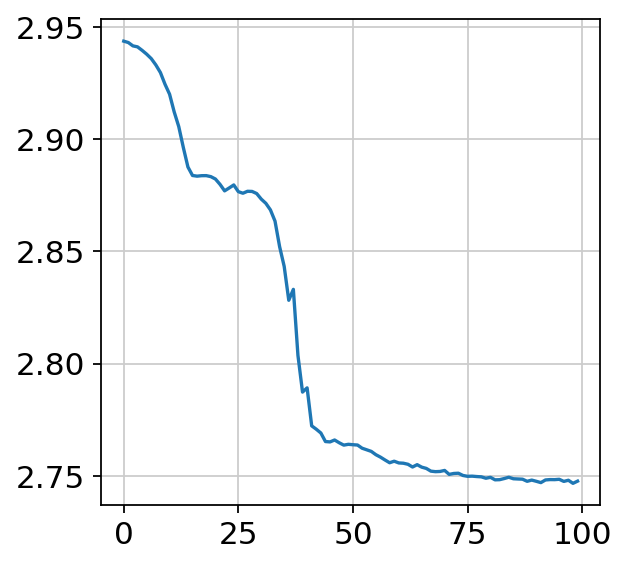

In [46]:
utils.seed(0) 

n_train = 1800 
NUM_EPOCHS = 100 
LR = 0.001 

n_inp = 64  # 256
n_hid = 256
n_layers = 2
n_heads = 4

#     Random initialize input feature
for ntype in G.ntypes:
    # emb = nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), n_inp), requires_grad = False)
    emb = nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), n_inp), requires_grad = True)
    nn.init.xavier_uniform_(emb)
    G.nodes[ntype].data['inp'] = emb.to(device)

# print(G.nodes['gene'].data['inp'][:3, :5])

model = HGT.HGT_GC(G,
            node_dict, edge_dict,
            n_inp=n_inp,
            n_hid=n_hid,
            n_out=labels.unique().shape[0],
            n_layers=n_layers,
            n_heads=n_heads,
            use_norm = True).to(device)
print(f'Training {type(model).__name__} with #param: {sum(p.numel() for p in model.parameters())}')

model, losses, accs = HGT.train(model, G, labels, n_train, NUM_EPOCHS, lr=LR, use_scheduler=True)
plt.plot(losses)

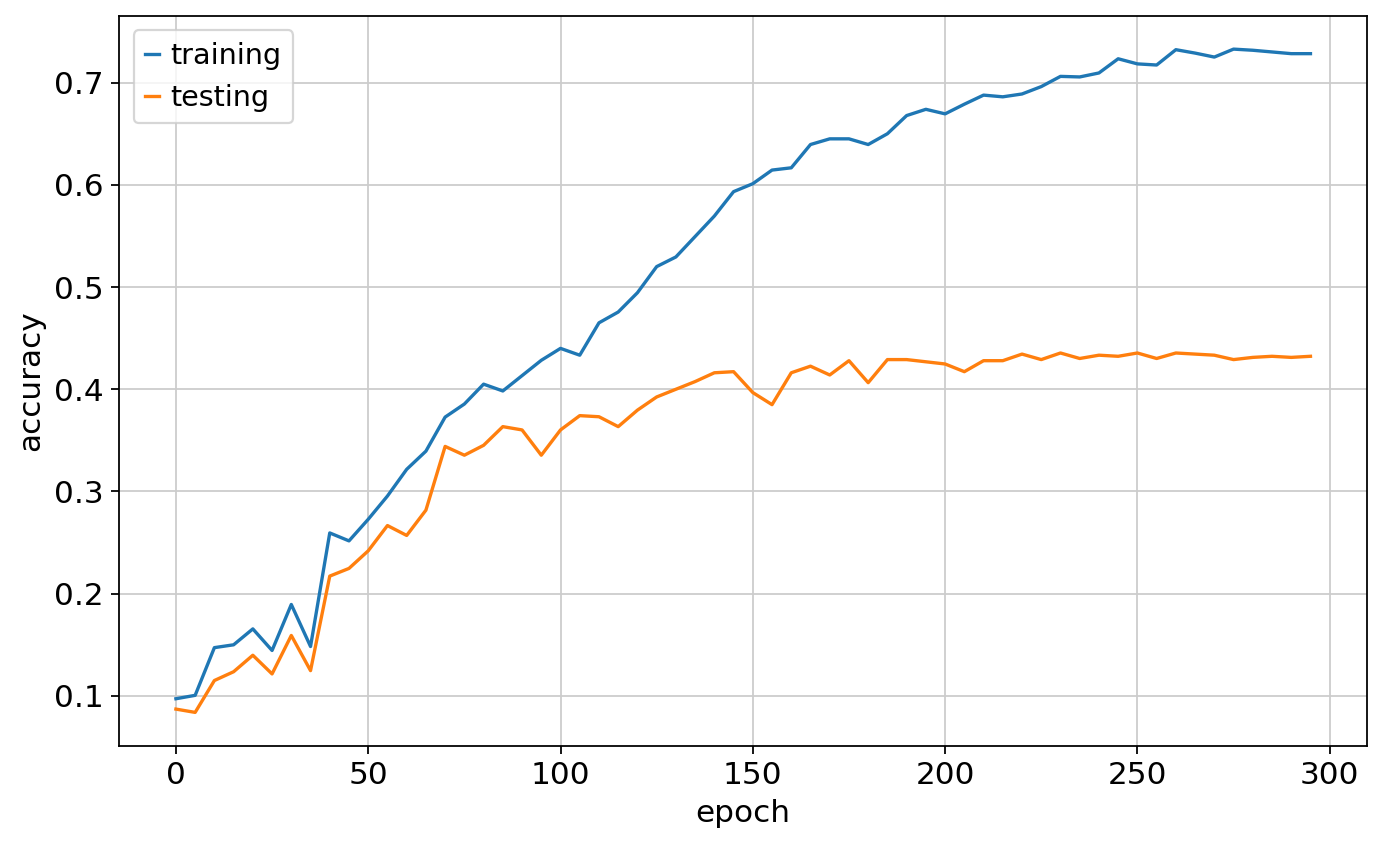

In [10]:
fig, ax = plt.subplots(figsize=(10, 6)) 
ax.plot(5 * np.arange(len(accs)), [i[0] for i in accs], label='training')
ax.plot(5 * np.arange(len(accs)), [i[1] for i in accs], label='testing')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()
fig.show()

In [23]:
G.nodes['gene'].data['inp']

tensor([[ 0.0718, -0.0798,  0.0401,  ...,  0.1857, -0.1393,  0.1468],
        [-0.0399,  0.1034, -0.0625,  ...,  0.1391, -0.0382, -0.1672],
        [ 0.1381,  0.1822, -0.1142,  ..., -0.1288, -0.0838, -0.0481],
        ...,
        [ 0.0869,  0.0462,  0.0648,  ..., -0.0062,  0.1410,  0.1892],
        [-0.0425,  0.1293, -0.0482,  ..., -0.0279, -0.1614, -0.1001],
        [-0.1233, -0.0649,  0.1340,  ...,  0.1180, -0.0341,  0.1299]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)